![Google](https://upload.wikimedia.org/wikipedia/commons/2/2f/Google_2015_logo.svg)
# **Deep Learning Summer Day con Google Cloud**
23 de Julio de 2020

Bienvenido a este notebook del Deep Learning Summer Day con Google Cloud, donde vamos a entrenar a una red neuronal a jugar al juego spot it.
El objetivo del juego es encontrar el simblo repetido en cada par de cartas, solo hay uno, el que primero lo encuentre gana!
![Spoit it](https://thumbs-prod.si-cdn.com/XYC9Mfk49L1nT3hbiJrDjYTHl2g=/800x600/filters:no_upscale():focal(627x536:628x537)/https://public-media.si-cdn.com/filer/b7/16/b716f299-f842-4133-822d-efd55e2adc3f/1359415822_w640_h640_spot_it_card_game.jpg)

Notebook parcialmente basado en [Medium post](https://towardsdatascience.com/how-i-learned-my-computer-to-play-spot-it-using-opencv-and-deep-learning-ad1f017a3ec3)

Atendiendo al ciclo de vida clasico de desarrollos ML, este notebook consta de tres secciones:
* FASE 1: Fase de captura y preparacion de datos
* FASE 2: Fase de entrenamiento
* FASE 3: Fase de prediccion

Primero vamos a instalar algunos paquetes que nos serviran para el procesado de imagenes.
```
paquetes necesarios: imutils
```
Tambien vamos a crear un directorio en nuestro entorno local para albergar los datos de entrenamiento. Para ello creamos simplemente una carpeta llamada symbols utilizando el comando:

```
mkdir symbols
```

In [44]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=470cc741fc3a38834320d7141ca519b4cb65b2cc8cc87f2107af4a98382f9464
  Stored in directory: /home/jupyter/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils


## FASE 1: Fase de captura y preparacion de datos

In [1]:
!rm -Rf symbols
!mkdir symbols

Ahora vamos a copiar los datos de entrenamiento desde Google Cloud Storage hasta el espacio local. Los datos ya estan previamente cargados en el notebook. Para realizar la copia de datos utilizaremos el comando:


```
gsutil cp gs://BUCKET_NAME directorio_local
```

Si tienes interes en el proceso de preparacion de datos (e.g. como hemos pasado de una imagen tomada con el movil a la extraccion de los simbolos, consulta el notebook asociado):

```
spot_it_dataprep.ipynb
```


In [2]:
!gsutil cp -R gs://velascoluis-test/dl_summer_day/model_data/* symbols

Copying gs://velascoluis-test/dl_summer_day/model_data/.DS_Store...
Copying gs://velascoluis-test/dl_summer_day/model_data/test/IMG_20200719_113349.jpg...
Copying gs://velascoluis-test/dl_summer_day/model_data/test/IMG_20200719_113419.jpg...
Copying gs://velascoluis-test/dl_summer_day/model_data/test/IMG_20200719_113427.jpg...
| [4 files][ 13.1 MiB/ 13.1 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://velascoluis-test/dl_summer_day/model_data/test/IMG_20200719_113444.jpg...
Copying gs://velascoluis-test/dl_summer_day/model_data/test/IMG_20200719_113509.jpg...
Copying gs://velascoluis-test/dl_summer_day/model_data/test/IMG_20200719_113535.jpg...
Copying gs://velascoluis-test/dl_summer_day/model_data/test/IMG_20200719_1135

Vamos a ver la pinta de algunas de las imagenes que hemos copiado, por ejemplo la imagen: 

```
symbols/train/art/19_IMG_20200719_113814.jpg_processed.jpg_icon2.jpg
```



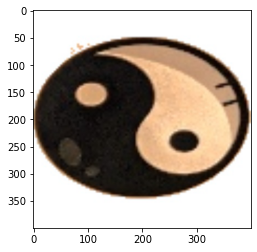

In [4]:
import matplotlib.pyplot as plt
import cv2
imagen='symbols/validation/yinyan/32_MVIMG_20200719_113301.jpg_processed.jpg_icon0.jpg'
imagen_cv2 = cv2.imread(imagen)
plt.imshow(imagen_cv2)

#### Knowledge check: por que hemos dividido los datos en tres carpetas?

Tenemos nuestros datos de entrenamiento y validacion preparados, ya podemos empezar a entrenar una red neuronal. Para ello vamos a utilizar tensorflow. La arquitectura de la red que vamos a desplegar es:
* 6 capas de convolucion + MaxPooling con 32,64,128,256,256 y 128 filtros de 3x3. Funcion de activacion reLu
* 1 capa Flatten
* 1 capa de regularizacion Dropout
* 1 Capa totalmente conectadas
* 1 Capa totalmente conectada de salida
Optimizador: RMSProp
Funcion de perdida: categorical crossentropy

## FASE 2: Fase de entrenamiento

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)))
model.add(layers.MaxPooling2D((2, 2)))  
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(57, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

#### Knowledge check: Cual son los 'output shapes' capa por capa?
#### Knowledge check: Que quiere decir lr = 1e-4?
#### Knowledge check: Por que tenemos 57 neuronas en la capa de salida?

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 256)       2

Ahora vamos a introducir los datos de entrenamiento y validacion utilizando las funciones de preparacion de datos de Tensorflow:


```
ImageDataGenerator
.flow_from_directory
```



In [9]:
train_dir = 'symbols/train'
validation_dir = 'symbols/validation'
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(400,400), batch_size=10, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(400,400), batch_size=5, class_mode='categorical')

Found 1659 images belonging to 57 classes.
Found 486 images belonging to 57 classes.


#### Cual es el cometido de esta linea de codigo?
```
(rescale=1./255, rotation_range=40, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=True)
```

Todo listo para lanzar el proceso de entrenamiento, aseguremonos que estamos utilizando un acelerador ASIC (e.g. GPU)

In [10]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=validation_generator, validation_steps=50)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 41s 405ms/step - loss: 3.9070 - acc: 0.0360 - val_loss: 3.6168 - val_acc: 0.0840
Epoch 2/100
100/100 [==============================] - 37s 367ms/step - loss: 3.2407 - acc: 0.1240 - val_loss: 2.8121 - val_acc: 0.1320
Epoch 3/100
100/100 [==============================] - 36s 361ms/step - loss: 2.6527 - acc: 0.2030 - val_loss: 2.2608 - val_acc: 0.2560
Epoch 4/100
100/100 [==============================] - 36s 361ms/step - loss: 2.2771 - acc: 0.2753 - val_loss: 2.2193 - val_acc: 0.3040
Epoch 5/100
100/100 [==============================] - 36s 365ms/step - loss: 1.9692 - acc: 0.3453 - val_loss: 1.7636 - val_acc: 0.4000
Epoch 6/100
100/100 [==============================] - 36s 362ms/step - loss: 1.7371 - acc: 0.4164 - val_loss: 1.6230 - val_acc: 0.3800
Epoch 7/100
100

Vamos a visualizar las metricas de convergencia del modelo, guardadas en la variable history

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


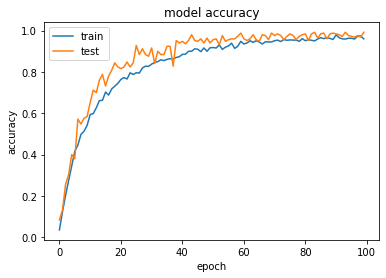

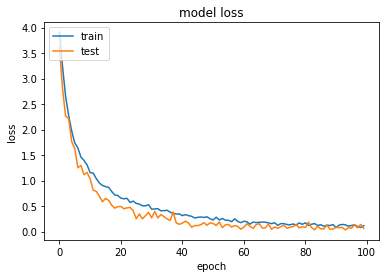

In [12]:
print(history.history.keys())
# Acc
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# sLoss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 256)       2

Copiamos el modelo pre-entrenado desde GCS a nuestro notebook

In [19]:
!gsutil  cp -R gs://velascoluis-test/dl_summer_day/spot_model .

Copying gs://velascoluis-test/dl_summer_day/spot_model/saved_model.pb...
Copying gs://velascoluis-test/dl_summer_day/spot_model/variables/variables.data-00000-of-00002...
Copying gs://velascoluis-test/dl_summer_day/spot_model/variables/variables.data-00001-of-00002...
Copying gs://velascoluis-test/dl_summer_day/spot_model/variables/variables.index...
| [4 files][ 42.2 MiB/ 42.2 MiB]                                                
Operation completed over 4 objects/42.2 MiB.                                     


In [20]:
model = tf.keras.models.load_model('spot_model')

## FASE 3: Fase de prediccion 

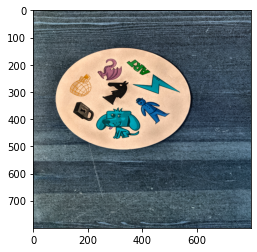

In [63]:
predict_dir = 'symbols/test/'
predict_filename = 'IMG_20200719_113557.jpg'
image = cv2.imread(predict_dir+predict_filename)
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
limg = cv2.merge((cl,a,b))
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
resized = cv2.resize(final, (800, 800))
plt.imshow(resized)

In [64]:
import imutils
!rm -Rf predictions
!mkdir -p predictions
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
thresh = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY)[1]
## find contours
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
output = image.copy()
## draw contours on image
for c in cnts:
    cv2.drawContours(output, [c], -1, (255, 0, 0), 3)
    ## sort by area, grab the biggest one
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
    ## create mask with the biggest contour
    mask = np.zeros(gray.shape,np.uint8)
    mask = cv2.drawContours(mask, [cnts], -1, 255, cv2.FILLED)
    ## card in foreground
    fg_masked = cv2.bitwise_and(image, image, mask=mask)
    ## white background (use inverted mask)
    mask = cv2.bitwise_not(mask)
    bk = np.full(image.shape, 255, dtype=np.uint8)
    bk_masked = cv2.bitwise_and(bk, bk, mask=mask)
    # combine back- and foreground
    final = cv2.bitwise_or(fg_masked, bk_masked)
    #plt.imshow(final)
    gray = cv2.cvtColor(final, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray, 195, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.bitwise_not(thresh)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
    # handle each contour
    i = 0
    for c in cnts:
        if cv2.contourArea(c) > 1000:
        # draw mask, keep contour
            mask = np.zeros(gray.shape, np.uint8)
            mask = cv2.drawContours(mask, [c], -1, 255, cv2.FILLED)
            # white background
            fg_masked = cv2.bitwise_and(image, image, mask=mask)
            mask = cv2.bitwise_not(mask)
            bk = np.full(image.shape, 255, dtype=np.uint8)
            bk_masked = cv2.bitwise_and(bk, bk, mask=mask)
            finalcont = cv2.bitwise_or(fg_masked, bk_masked)
            # bounding rectangle around contour
            output = finalcont.copy()
            x,y,w,h = cv2.boundingRect(c)
            # squares io rectangles
            if w < h:
                x += int((w-h)/2)
                w = h
            else:
                y += int((h-w)/2)
                h = w
            # take out the square with the symbol
            roi = finalcont[y:y+h, x:x+w]
            try:
                roi = cv2.resize(roi, (400,400))
                cv2.imwrite('predictions/'+predict_filename+'_icon'+str(i)+'.jpg', roi)
            except Exception:
                pass
            i += 1

In [69]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('predictions',target_size=(400, 400),batch_size=20,class_mode='binary',shuffle=False)
test_generator.reset()
pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
predicted_probabilities = np.max(pred,axis=1)
predicted_class_indices = np.argmax(pred,axis=1)

Found 8 images belonging to 1 classes.
1/1 [==============================] - 0s 476ms/step


Valores de referencia para la clasificacion:
* 1 - Ajedrez
* 2 - Ancla
* 3 - Araña
* 4 - Arbol
* 5 - ART
* 6 - Biberon
* 7 - Bomba
* 8 - Bombilla
* 9 - Cactus
* 10 - Calavera
* 11 - Candado
* 12 - Coche
* 13 - Coponieve
* 14 - Corazon
* 15 - Cubito
* 16 - Delfin
* 17 - Diana
* 18 - Dragon
* 19 - Exclamacion
* 20 - Fantasmita
* 21 - Fuego
* 22 - Gafas sol
* 23 - Gato
* 24 - Globo
* 25 - Gota
* 26 - Hombre
* 27 - Iglu
* 28 - Interrogacion
* 29 - Labios
* 30 - Lapiz
* 31 - Llave
* 32 - Luna
* 33 - Mancha
* 34 - Mano
* 35 - Manzana
* 36 - Maple
* 37 - Margarita
* 38 - Mariquita
* 39 - Musica
* 40 - Ojo
* 41 - OK
* 42 - Payaso
* 43 - Perro
* 44 - Queso
* 45 - Rayo
* 46 - Reloj
* 47 - snowman
* 48 - Sol
* 49 - Stop
* 50 - Tela araña
* 51 - Tijeras
* 52 - Trebol
* 53 - TRex
* 54 - Vela
* 55 - Yin-yan
* 56 - Zanahoria
* 57 - Zebra

In [70]:
print(predicted_probabilities)

[0.999998   0.99999547 0.9999639  0.9838991  0.99986315 0.99987423
 0.98454547 0.9999956 ]


In [71]:
print(predicted_class_indices)

[42 26 27  1 44 18 11  5]
